### Objective of Competition:
- Predict the rating that a user would give to movie that he not yet rated
- minimise the difference between predicted and actual rating (RMSE and MAPE)
### Constraint : 
- It should be Interpretable

### Dataset for Netflix Recommendation
- Source:- https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data
- Overview: 
    - Training Dataset:
        - "training_set.tar" conatins:
            - MovieIDs range from 1 to 17770 sequentially.
            - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
            - Ratings are on a five star (integral) scale from 1 to 5.
            - Dates have the format YYYY-MM-DD.
    - Movie Information
        - "movie_titles.txt" Contains the movie Information
            - MovieID : unique id given to each movie
            - YearOfRelease: range from 1805 to 2005
            - Title: title on netflix for an movie
     - Testing Dataset
        - "qualifying.txt" it conatins movie id for each of them it had
            - customer ids and rating dates

### Mapping it to the ML Problem:
    - This Can be trated as either Recommendation Problem that find the missing values of user-movie matrix 
    - Regression Problem For given a user details find the Rating it can give

### Exploratory Data Analysis of Netflix Prixe Data

In [ ]:
# Load Dataset
files=['netflix-prize-data/combined_data_1.txt','netflix-prize-data/combined_data_2.txt','netflix-prize-data/combined_data_3.txt','netflix-prize-data/combined_data_4.txt']
directory='/kaggle/input/'
# create an csv file
data =open('data.csv',mode='w')
data.write(','.join(['movie_id','customer_id','rating,date']))
data.write('\n')
for i in files:
    with open(directory+i) as f:
        for line in f:
            line=line.strip()
            if(line.endswith(':')):
                movie_id=line.replace(':','')
            else:
                row=[x for x in line.split(',')]
                row.insert(0,movie_id)
                data.write(','.join(row))
                data.write('\n')
data.close()

In [8]:
import pandas as pd
df=pd.read_csv('/kaggle/input/netflix-combined-data/data.csv')

In [2]:
# convert the date column as datetime object
df.date=pd.to_datetime(df.date)
# sort the data frame according to Date
df.sort_values(by='date',inplace=True)

In [3]:
#features of dataset
df.columns
# few  top instance of dataset
df.head()
# data from 11-11-1999

,movie_id,customer_id,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [4]:
df.tail()
# data till 31-12-2005

,movie_id,customer_id,rating,date
49939086,8993,2183787,4,2005-12-31
42072268,7430,258170,4,2005-12-31
47098649,8467,1534359,5,2005-12-31
55621336,10168,2543295,2,2005-12-31
25464092,4736,1346243,5,2005-12-31


In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
std      1.085219e+00
Name: rating, dtype: float64

In [6]:
# check for null values
print("No of NAN Values",sum(df.isnull().any()))
# As we can see there are no null values

No of NAN Values 0


In [7]:
# check for Diplicates
print("No of Duplicates",sum(df.duplicated(['movie_id','customer_id','rating'])))
# there are no duplicates as well

No of Duplicates 0


In [8]:
# Basic Statistics of Dataset
# number of user
# number of ratings
# number of movies 
print("Number of user",len(df['customer_id'].unique()))
print("="*60)
print("Number of Ratings",df.shape[0])
print("="*60)
print("Number of movies",len(df['movie_id'].unique()))
print("="*60)

Number of user 480189
Number of Ratings 100480507
Number of movies 17770


In [9]:
# split the dataset in train and test in 80 to 20 also we do it based on date
# top 80% rows as train as they are already sorted in the ascending order of date
train=df[:(df.shape[0]*8)//10]
# 20 % of them as test
test=df[(df.shape[0]*8)//10:]

In [10]:
len(train.rating)

80384405

### Using Plots understands about the dataset

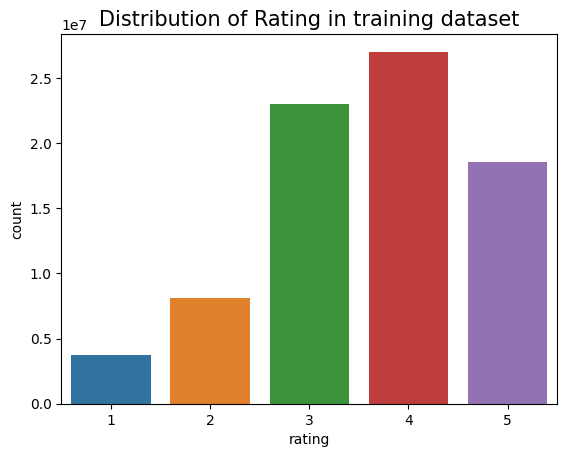

In [11]:
# Distribution of rating
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax=plt.subplots()
plt.title("Distribution of Rating in training dataset",fontsize=15)
sns.countplot(x=train.rating)
plt.show()
# maximum number of rating given is rating as '4' 

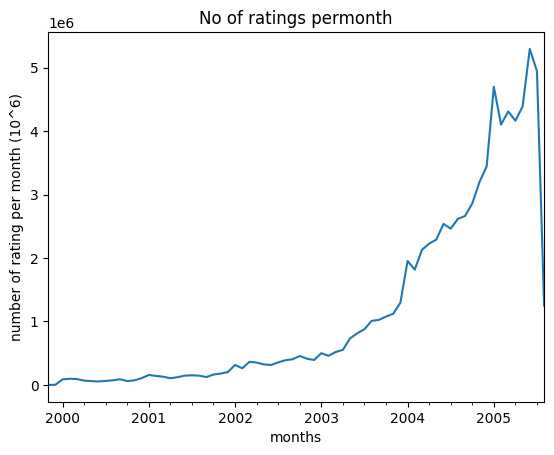

In [12]:
# number of rating per month
ax=train.resample('m',on='date')['rating'].count().plot()
ax.set_title("No of ratings permonth")
plt.xlabel('months')
plt.ylabel('number of rating per month (10^6)')
plt.show()

In [12]:
# Number of movies rated by each users
rated_movie= train.groupby(by='customer_id')['rating'].count().sort_values(ascending=False)
rated_movie.head()
# for a user 305344 given approx 17000 movies which is too high 

customer_id
305344     14382
387418     14219
2439493    13484
1664010    12902
2118461    12073
Name: rating, dtype: int64

In [13]:
# statistics for the rated_movie
rated_movie.describe()
# as we can see with the statistics is 75% percentile are only 245 movies 
# so lets remove the movies with rating > 3*IQR and we can't trim from start because
# rating could be zero as well since an user watched no movies

count    479670.000000
mean        167.582724
std         244.075568
min           1.000000
25%          30.000000
50%          77.000000
75%         207.000000
max       14382.000000
Name: rating, dtype: float64

In [14]:
# remove the rows with rating> 3*IQR
# Calculate the IQR
Q1 = rated_movie.quantile(0.25)
Q3 = rated_movie.quantile(0.75)
IQR = Q3 - Q1

# Define the upper limit for outliers
upper_limit = Q3 + 3 * IQR

# Remove rows with ratings greater than the upper limit
filtered_train = train[~train['customer_id'].isin([i for i in rated_movie.index if rated_movie[i] > upper_limit])]
# see the remaning 
remianing= filtered_train.groupby(by='customer_id')['rating'].count().sort_values(ascending=False)
remianing.head()
# As we can see maximum review given by an user remain is 878 which looks fisibile and outliers are removed

customer_id
1617676    738
1414072    738
1097806    738
2013678    738
2389578    738
Name: rating, dtype: int64

In [15]:
filtered_train.head()

,movie_id,customer_id,rating,date
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
4,1,823519,3,2004-05-03
5,1,893988,3,2005-11-17
6,1,124105,4,2004-08-05


In [16]:
remianing.describe()

count    463299.000000
mean        135.369042
std         152.503986
min           1.000000
25%          29.000000
50%          72.000000
75%         186.000000
max         738.000000
Name: rating, dtype: float64

### No of Rating each movie have?

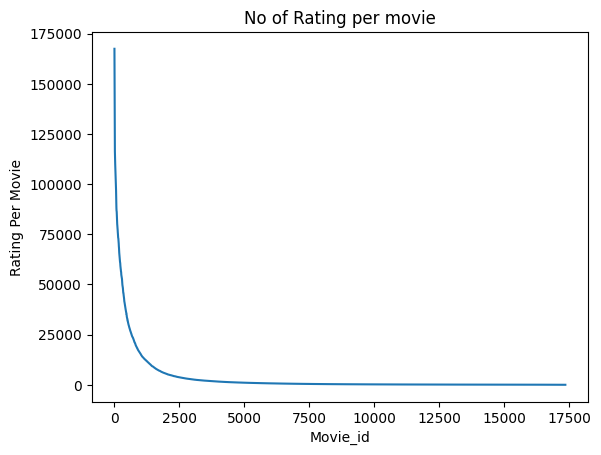

In [18]:
rating_per_movie=filtered_train.groupby(by='movie_id')['rating'].count().sort_values(ascending=False)
plt.plot(rating_per_movie.values)
plt.title("No of Rating per movie")
plt.xlabel("Movie_id")
plt.ylabel("Rating Per Movie")
plt.show()
# some of the movies having too much  rating while most of them have few rating
# as there are very few movies which are famous so only for those it have lots of ratings
# for very large movie there are very few rating as we can see from the plot

In [19]:
rating_per_movie.describe()

count     17349.000000
mean       3592.231887
std       11877.295383
min           1.000000
25%         100.000000
50%         288.000000
75%        1357.000000
max      167448.000000
Name: rating, dtype: float64

### Create an user-movie sparse matrix
- rows are the users and columns are movies and each cell contains the rating given by a user to a movie.
- There are ~ 18000 movies and maximum rating given by almost 90% of user is less then ~300 and even 50% of them given rating less then < 90 so we can create an sparse matrix represention for this matrix

In [ ]:
# csr_matrix used to create and sparse matrix
from scipy import sparse
user_movie_matrix=sparse.csr_matrix((filtered_train.rating.values,(filtered_train.customer_id.values,filtered_train.movie_id.values)),)
sparse.save_npz('/kaggle/working/user_movie_train.npz',user_movie_matrix)

In [ ]:
# similarly for test data
from scipy import sparse
sparse.save_npz('/kaggle/working/user_movie_test.npz',sparse.csr_matrix((test.rating.values,(test.customer_id.values,test.movie_id.values)),))

In [1]:
## load the matrices
from scipy import sparse
user_movie_matrix=sparse.load_npz('/kaggle/input/netflix-combined-data/user_movie_train.npz')
user_movie_matrix_test=sparse.load_npz('/kaggle/input/netflix-combined-data/user_movie_test.npz')

In [23]:
user,movie=user_movie_matrix.shape
elem=user_movie_matrix.count_nonzero()
print('Sparsity of Matrix',((1-elem/(user*movie))*100))
# 99% of element have zeros in that matrix

Sparsity of Matrix 99.86763459459809


### Cold Start Problem of Recommendation System
- It happens Because of new Movies and new Users
- Here as well many user and many movies might not in the training as well

### Compute the Similarity matrices 
- Between user-user 
- Between movie-movie 

In [5]:
#Between user-user using cosine Distance
# as we know that matrix size we get as 390k*390K and this will be an dense matrix
# because between every user there will some similarity
# so instead of computing the for all user to all other user compute the
# one of the way is compute the similarity whenever it needed
# along with it maintain an boolean vector that say weather or not it computed
# also an dictionery containing the top similar to this user
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
import numpy as np

def top_similar_users(user_movie, user_to_compute, top_n=10):
    """
    Find the top N rows with higher cosine similarity and lower distances to the given row.

    Parameters:
    - matrix: Sparse matrix (CSR format)
    - given_row_index: Index of the given row
    - top_n: Number of top rows to retrieve

    Returns:
    - top_rows: List of indices of the top N rows
    """

    # Extract the given row
    user = user_movie.getrow(user_to_compute)
    # Compute pairwise distances with cosine metric
    distnace_users = pairwise_distances(user_movie, user, metric='cosine').ravel()

    # Extract indices of the top N rows based on similarity (lower distances)
    top_users = np.argsort(distnace_users)[:top_n]

    return top_users,user

In [6]:
user_movie_matrix.getrow(3)

<1x17771 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [17]:
similar,user=top_similar_users(user_movie_matrix,3,20)
similar_user = filtered_train.iloc[similar]
print(similar_user)
# with this we can compute the similar users for any user
#



done
         movie_id  customer_id  rating        date
1               1       822109       5  2005-05-13
2260486       427      2326969       3  2004-01-28
2260488       427      1814740       3  2003-11-24
2260489       427      2569204       2  2003-12-19
2260490       427       190037       3  2003-12-02
2260493       427      2493028       4  2005-02-23
2260494       427      1835777       4  2005-04-19
2260497       427      1558821       2  2003-04-08
2260483       427      1660219       3  2003-10-12
2260501       427       512477       1  2004-01-05
2260506       427       479853       2  2004-01-03
2260512       427       284762       5  2005-04-08
2260513       427        42094       4  2005-06-28
2260514       427       111645       3  2005-10-18
2260515       427      2532737       3  2004-01-22
2260517       427      1489091       3  2003-09-19
2260523       427      1407758       1  2003-12-05
2260502       427        95373       3  2003-05-10
2260526       427       7

In [37]:
#Between movie-movie similarity 
from sklearn.metrics.pairwise import cosine_similarity
m_m_similarity=cosine_similarity(X=user_movie_matrix.T,dense_output=True)

In [ ]:
# store the movie movie similarity 
sparse.save_npz('/kaggle/working/m_m_similarity.npz',m_m_similarity)

In [18]:
## check if this will work for or for given a movie does it recommend most similar movies
# checking by using the movie title given
# load the movie title
import pandas as pd
# Read CSV and skip specified rows
title=pd.read_csv('/kaggle/input/netflix-combined-data/title.csv')
print(title.head())

   Movie_Id    year                          Name
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW


In [49]:
# find top k similar movie
def getSimilarMovie(mm_similar,k,index):
    """
    Top K similar movie for given index based on movie movies similarity
    """
    return np.argsort(m_m_similarity[index])[1:k+1]
similar_movie=getSimilarMovie(m_m_similarity,5,2324)

In [50]:
print(title[title['Movie_Id']==2324])
for i in similar_movie:
    print(title[title['Movie_Id']==i])

      Movie_Id    year            Name
2323      2324  2002.0  House of Fools
       Movie_Id    year                                               Name
12466     12467  1999.0  Sing a Song With Pooh Bear and Piglet Too: Sin...
      Movie_Id    year                                               Name
5551      5552  2005.0  Mobile Suit Gundam SEED the Movie 2: The Far-A...
      Movie_Id    year                    Name
5550      5551  2002.0  The Year That Trembled
       Movie_Id    year                  Name
12467     12468  1977.0  You Light Up My Life
       Movie_Id    year                                         Name
12473     12474  1998.0  Beauty and the Beast: Belle's Magical World


### Understanding About Surprise Library for Recommendation Systems
- This Library haev ready to use prediction algorithm like baseline,neighbourhood mthods , different matrix factorization Algorithms(SVD,PMF,SVD++,NMF) ....
- Winner is yahuda koren is one the team memeber who won the netflix prize and also there is research paper
- In this workshop studying many different algorithm for recommnedation using surprise
- Also since the dataset is too Big it will better to sample the data and once we know which algorithm and strategy gives better results we can apply that to all data
- As a sample taking 5000user and 500 movies as test and 20K user and 2K movies as train



In [2]:
# Creating sample 
# Get the indices of non-zero entries in the sparse matrix
import numpy as np
user_indices, movie_indices = user_movie_matrix.nonzero()

# Randomly sample 10,000 users and 1,000 movies
selected_user_indices = np.random.choice(np.unique(user_indices), size=10000, replace=False)
selected_movie_indices = np.random.choice(np.unique(movie_indices), size=1000, replace=False)

# Create a subset of the sparse matrix based on the sampled indices
sampled_user_movie_matrix = user_movie_matrix[selected_user_indices][:, selected_movie_indices]


In [3]:
# similarly for test
sampled_test=user_movie_matrix_test.nonzero()
# Randomly sample 500 users and 500 movies
selected_user_indices = np.random.choice(np.unique(user_indices), size=5000, replace=False)
selected_movie_indices = np.random.choice(np.unique(movie_indices), size=500, replace=False)
# Create a subset of the sparse matrix based on the sampled indices
sampled_user_movie_test = user_movie_matrix_test[selected_user_indices][:, selected_movie_indices]


### Featurization for Regression
- Features:
    - GAvg: Average Rating of all the ratings
    - top 5 similar user whot rated that movie  
    - top5 similar movies rated by the user
    - UAvg: user's average rating
    - MAvg Average ratings for the movie
    - rating rating for this movie by this user (this is y_train)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
def getRow(user,movie):
    """
    Given user Index and movie Index get the row for the dataset
    """
    row=[]
    # Feature 1: Global Average Rating
    global_avg_rating = sampled_user_movie_matrix.sum()/sampled_user_movie_matrix.count_nonzero()
    row.append(global_avg_rating)
    # Feature 2: Top 5 rating given by the similar user to this movie
    user_similarity_matrix = cosine_similarity(sampled_user_movie_matrix.T)
    top5_similar_users = np.argsort(user_similarity_matrix[:, user])[::-1][1:6]
    row+=top5_similar_users
    # Feature 3: Top 5 rating given by the similar user to this movie
    movie_similarity_matrix = cosine_similarity(sampled_user_movie_matrix)
    top5_similar_movies = np.argsort(movie_similarity_matrix[movie, :])[::-1][1:6]
    row+=top5_similar_users
    # Feature 4: User's Average Rating (UAvg)
    user_avg_rating = np.mean(sampled_user_movie_matrix[0, :])
    # Feature 5: Average Ratings for the Movie (MAvg)
    movie_avg_rating = np.mean(sampled_user_movie_matrix[:, 0])
    # Feature 6: Rating for this movie by this user (this is y_train)
    target_rating = sampled_user_movie_matrix[0, 0]
    return top5_similar_users+top5_similar_movies


In [23]:
print(sampled_user_movie_matrix[:, 0].sum()/sampled_user_movie_matrix[:, 0].count_nonzero())

4

In [26]:
sampled_user_movie_matrix.sum()/sampled_user_movie_matrix.count_nonzero()

3.6991870636314688

In [27]:
x=[1,2,3]
y=[2,3,4]
x=x+y
print(x)

[1, 2, 3, 2, 3, 4]
